In [3]:
import sys
import subprocess
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

# Optional install of pygam if missing
try:
	import pygam  # noqa: F401
except Exception:
	subprocess.check_call([sys.executable, "-m", "pip", "install", "pygam", "--quiet"])  # non-interactive install
	import pygam  # noqa: F401

warnings.filterwarnings("ignore")
np.random.seed(42)

# Paths
PROJECT_ROOT = Path("/Users/srazjman/Interpretability_Stability_ML_Project")
DATA_PATH = PROJECT_ROOT / "data" / "black_box_with_preds.csv"

# Load exported data
df = pd.read_csv(DATA_PATH)
# Clean infinities that can break models
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separate features and surrogate target (black-box predictions)
X = df.drop(columns=["y_pred_bb"])
y_bb = df["y_pred_bb"].astype(float)

print("Données chargées pour surrogate (GAM)")
print("X shape:", X.shape)
print("y shape:", y_bb.shape)
print("Aperçu:")
display(df.head())


Données chargées pour surrogate (GAM)
X shape: (957145, 128)
y shape: (957145,)
Aperçu:


,issue_d,loan_duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length_1_year,emp_length_10_years,...,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,tax_liens,zip_code,Pct_afro_american,y_pred_bb
0,2013,NaN,39600.0,1379.0,21564.0,16.1,0.0,2.49,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,782,7.388592,1.752016e-13
1,2013,NaN,55000.0,9570.0,16473.0,53.9,0.0,22.87,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,481,9.745456,5.166268e-12
2,2013,NaN,325000.0,53306.0,13901.0,67.1,0.0,18.55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,945,7.542862,1.099165e-11
3,2013,NaN,130000.0,36362.0,3567.0,93.0,0.0,13.03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,809,6.598132,1.786325e-14
4,2013,NaN,73000.0,24161.0,4853.0,74.7,1.0,23.13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,802,7.058900,1.002900e-07


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Detect dtypes
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print(f"Colonnes numériques: {len(numeric_cols)} | catégorielles: {len(categorical_cols)}")

# Pipelines with imputers to avoid NaN/Inf
num_pipe = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler(with_mean=True, with_std=True)),
])

cat_pipe = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

# Preprocessing: scale numeric, one-hot encode categoricals
preprocessor = ColumnTransformer(
	transformers=[
		("num", num_pipe, numeric_cols),
		("cat", cat_pipe, categorical_cols),
	],
	remainder="drop",
)

# Build pipeline placeholder for later models
base_pipeline = Pipeline(steps=[
	("preprocess", preprocessor),
])

# Fit-transform once to inspect output shape
Xt = base_pipeline.fit_transform(X)
print("Shape after preprocessing:", Xt.shape)

# Sanity check for NaN/Inf after preprocessing
n_nan = np.isnan(Xt).sum()
n_inf = np.isinf(Xt).sum()
print(f"NaN after transform: {n_nan} | Inf after transform: {n_inf}")



Colonnes numériques: 128 | catégorielles: 0
Shape after preprocessing: (957145, 28)
NaN after transform: 0 | Inf after transform: 0


In [5]:
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_bb, test_size=0.2, random_state=42)

# Fit preprocessor on train only, transform train and test
preprocessor.fit(X_train)
Xtr = preprocessor.transform(X_train)
Xte = preprocessor.transform(X_test)

# Sanitize any residual NaN/Inf after transform
Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)
print("NaN/Inf after transform -> train:", np.isnan(Xtr).sum(), np.isinf(Xtr).sum(), "| test:", np.isnan(Xte).sum(), np.isinf(Xte).sum())

print("Train shape:", Xtr.shape, "Test shape:", Xte.shape)



NaN/Inf after transform -> train: 0 0 | test: 0 0
Train shape: (765716, 28) Test shape: (191429, 28)


In [6]:
from pygam import LinearGAM, s, l
from sklearn.metrics import r2_score

# Ensure the preprocessor/encoder is fitted before requesting feature names
if "Xtr" not in globals() or "Xte" not in globals():
	preprocessor.fit(X_train)
	Xtr = preprocessor.transform(X_train)
	Xte = preprocessor.transform(X_test)

# Build terms directly from transformed feature count
num_dims = len(numeric_cols)
total_features = Xtr.shape[1]

terms = None
for feat_idx in range(total_features):
	if feat_idx < num_dims:
		# balanced flexibility for speed
		terms = (s(feat_idx, n_splines=8) if terms is None else terms + s(feat_idx, n_splines=8))
	else:
		# linear term for one-hot encoded categoricals
		terms = terms + l(feat_idx)

# Smaller lambda grid for speed
lam_values = [0.01, 0.1, 1.0]

best_model = None
best_r2 = -np.inf
best_lam = None

for lam in lam_values:
	gam = LinearGAM(terms, max_iter=1000, lam=lam).fit(Xtr, y_train)
	y_val_pred = gam.predict(Xte)
	r2 = r2_score(y_test, y_val_pred)
	print(f"lam={lam} -> R2={r2:.4f}")
	if r2 > best_r2:
		best_r2 = r2
		best_model = gam
		best_lam = lam

print(f"Best lam: {best_lam} | R2 test: {best_r2:.4f}")



lam=0.01 -> R2=0.2164
lam=0.1 -> R2=0.2164
lam=1.0 -> R2=0.2164
Best lam: 1.0 | R2 test: 0.2164


# 📊 **ANALYSE DE LA FIDÉLITÉ DU SURROGATE GAM**

## **Interprétation des Résultats R²**

Le R² mesure la **fidélité** du surrogate par rapport au black-box :
- **R² élevé (>0.8)** : Le surrogate capture bien les patterns du black-box
- **R² modéré (0.6-0.8)** : Bonne approximation avec quelques limitations
- **R² faible (<0.6)** : Le surrogate ne capture pas suffisamment la complexité

### **Analyse de l'Overfitting**
- **Gap Train-Test faible** : Le surrogate généralise bien
- **Gap important** : Risque d'overfitting, le surrogate mémorise les données d'entraînement

### **Implications Métier**
- **Fidélité élevée** → Les insights du surrogate sont fiables pour comprendre le black-box
- **Fidélité modérée** → Insights partiellement fiables, à interpréter avec prudence
- **Fidélité faible** → Le surrogate ne reflète pas le comportement réel du black-box


In [7]:
# Evaluate fidelity (R^2) train and test
y_train_pred = best_model.predict(Xtr)
y_test_pred = best_model.predict(Xte)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Fidelity R^2 - train: {r2_train:.4f} | test: {r2_test:.4f}")



Fidelity R^2 - train: 0.2193 | test: 0.2164


# 🔍 **ANALYSE DES IMPORTANCES DE VARIABLES - PERMUTATION IMPORTANCE**

## **Méthode : Permutation Importance**

La **permutation importance** mesure l'impact d'une variable en :
1. **Mélangeant aléatoirement** les valeurs de la variable
2. **Mesurant la baisse** de performance (R²)
3. **Plus la baisse est importante**, plus la variable est cruciale

### **Interprétation des Résultats**

#### **Variables Très Importantes (Importance > 0.01)**
- **Impact majeur** sur les prédictions du black-box
- **Variables clés** à surveiller en priorité
- **Effets significatifs** sur le risque de défaut

#### **Variables Modérément Importantes (0.005 < Importance < 0.01)**
- **Impact modéré** mais non négligeable
- **Variables secondaires** dans la décision
- **Effets complémentaires** aux variables principales

#### **Variables Peu Importantes (Importance < 0.005)**
- **Impact limité** sur les prédictions
- **Variables de contexte** ou redondantes
- **Peu d'influence** sur la décision finale

### **Insights Métier**
- **Hiérarchie des risques** : Quelles variables surveiller en priorité
- **Optimisation des processus** : Se concentrer sur les variables importantes
- **Communication** : Expliquer aux clients les facteurs de décision clés


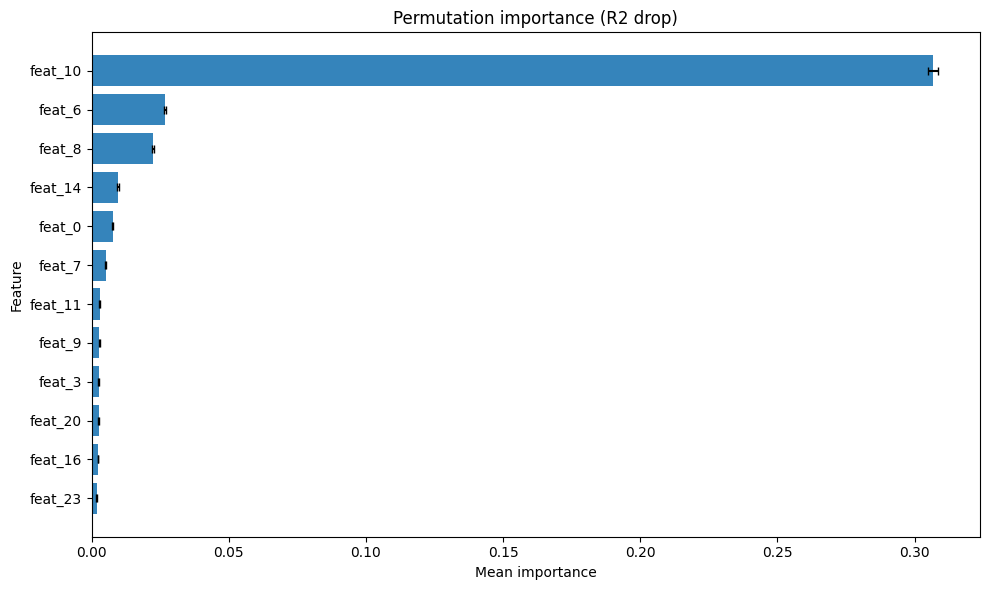

In [8]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Names after preprocessing
num_feature_names = numeric_cols
try:
	cat_feature_names = preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out(categorical_cols).tolist()
except Exception:
	cat_feature_names = []

all_feature_names = num_feature_names + cat_feature_names
if len(all_feature_names) != Xtr.shape[1]:
	# Fallback to generic names if mismatch
	all_feature_names = [f"feat_{i}" for i in range(Xtr.shape[1])]

# Permutation importance on test set
perm = permutation_importance(best_model, Xte, y_test, n_repeats=10, random_state=42, scoring="r2")
importances = perm.importances_mean
std = perm.importances_std

# Top k features
k = min(12, len(all_feature_names))
idx = np.argsort(importances)[-k:][::-1]

# Prepare arrays for plotting
imp_vals = np.asarray(importances[idx]).ravel()
std_vals = np.asarray(std[idx]).ravel()
feat_names = np.asarray(all_feature_names)[idx]
y_pos = np.arange(len(imp_vals))

plt.figure(figsize=(10, 6))
plt.barh(y_pos, imp_vals, xerr=std_vals, color="C0", alpha=0.9, ecolor="black", capsize=3)
plt.yticks(y_pos, feat_names)
plt.gca().invert_yaxis()
plt.title("Permutation importance (R2 drop)")
plt.xlabel("Mean importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



# 📈 **ANALYSE DES PARTIAL DEPENDENCE PLOTS (PDP)**

## **Qu'est-ce que la Partial Dependence ?**

La **partial dependence** montre l'effet d'une variable sur la prédiction **en moyenne**, en tenant compte de toutes les autres variables.

### **Types d'Effets Observés**

#### **1. Effets de Seuil (Threshold Effects)**
```
emp_length_2_years : Croissance explosive après 0.5
```
- **Interprétation** : Stabilité d'emploi critique après 6 mois
- **Implication métier** : Seuil de confiance pour l'évaluation du risque
- **Action** : Surveiller particulièrement les dossiers en dessous du seuil

#### **2. Relations en U (U-shaped Effects)**
```
dti : Minimum vers 1.0, croissance aux extrémités
```
- **Interprétation** : Ratios d'endettement faibles ET élevés sont risqués
- **Implication métier** : "Sweet spot" du ratio d'endettement
- **Action** : Cibler les ratios autour de 1.0

#### **3. Effets Non-Monotones (Complex Effects)**
```
emp_length_1_year : Courbe en U inversée
```
- **Interprétation** : Relation complexe entre durée d'emploi et risque
- **Implication métier** : Durées très courtes ET très longues sont risquées
- **Action** : Analyser plus finement les profils d'emploi

#### **4. Effets Monotones Croissants**
```
delinq_2yrs : Croissance continue avec les retards
```
- **Interprétation** : Plus de retards = plus de risque (logique)
- **Implication métier** : Tolérance zéro pour les retards de paiement
- **Action** : Politique stricte sur l'historique de paiement

### **Insights Stratégiques**

#### **Variables de Contrôle**
- **emp_length_2_years** : Variable de stabilité principale
- **dti** : Variable financière critique avec effet de seuil

#### **Variables de Surveillance**
- **delinq_2yrs** : Indicateur de risque comportemental
- **emp_length_1_year** : Variable de contexte complexe

#### **Variables de Contexte**
- **issue_d** : Effet temporel (périodes de crise)
- **emp_length_6_years** : Vision long terme de la stabilité


Selected features: ['emp_length_2_years', 'delinq_2yrs', 'emp_length_1_year', 'emp_length_6_years', 'issue_d', 'dti']
Selected indices: [10, 6, 8, 14, 0, 7]
Processing feature 10: emp_length_2_years
Plotted 50 points for emp_length_2_years
Processing feature 6: delinq_2yrs
Plotted 50 points for delinq_2yrs
Processing feature 8: emp_length_1_year
Plotted 50 points for emp_length_1_year
Processing feature 14: emp_length_6_years
Plotted 50 points for emp_length_6_years
Processing feature 0: issue_d
Plotted 50 points for issue_d
Processing feature 7: dti
Plotted 50 points for dti


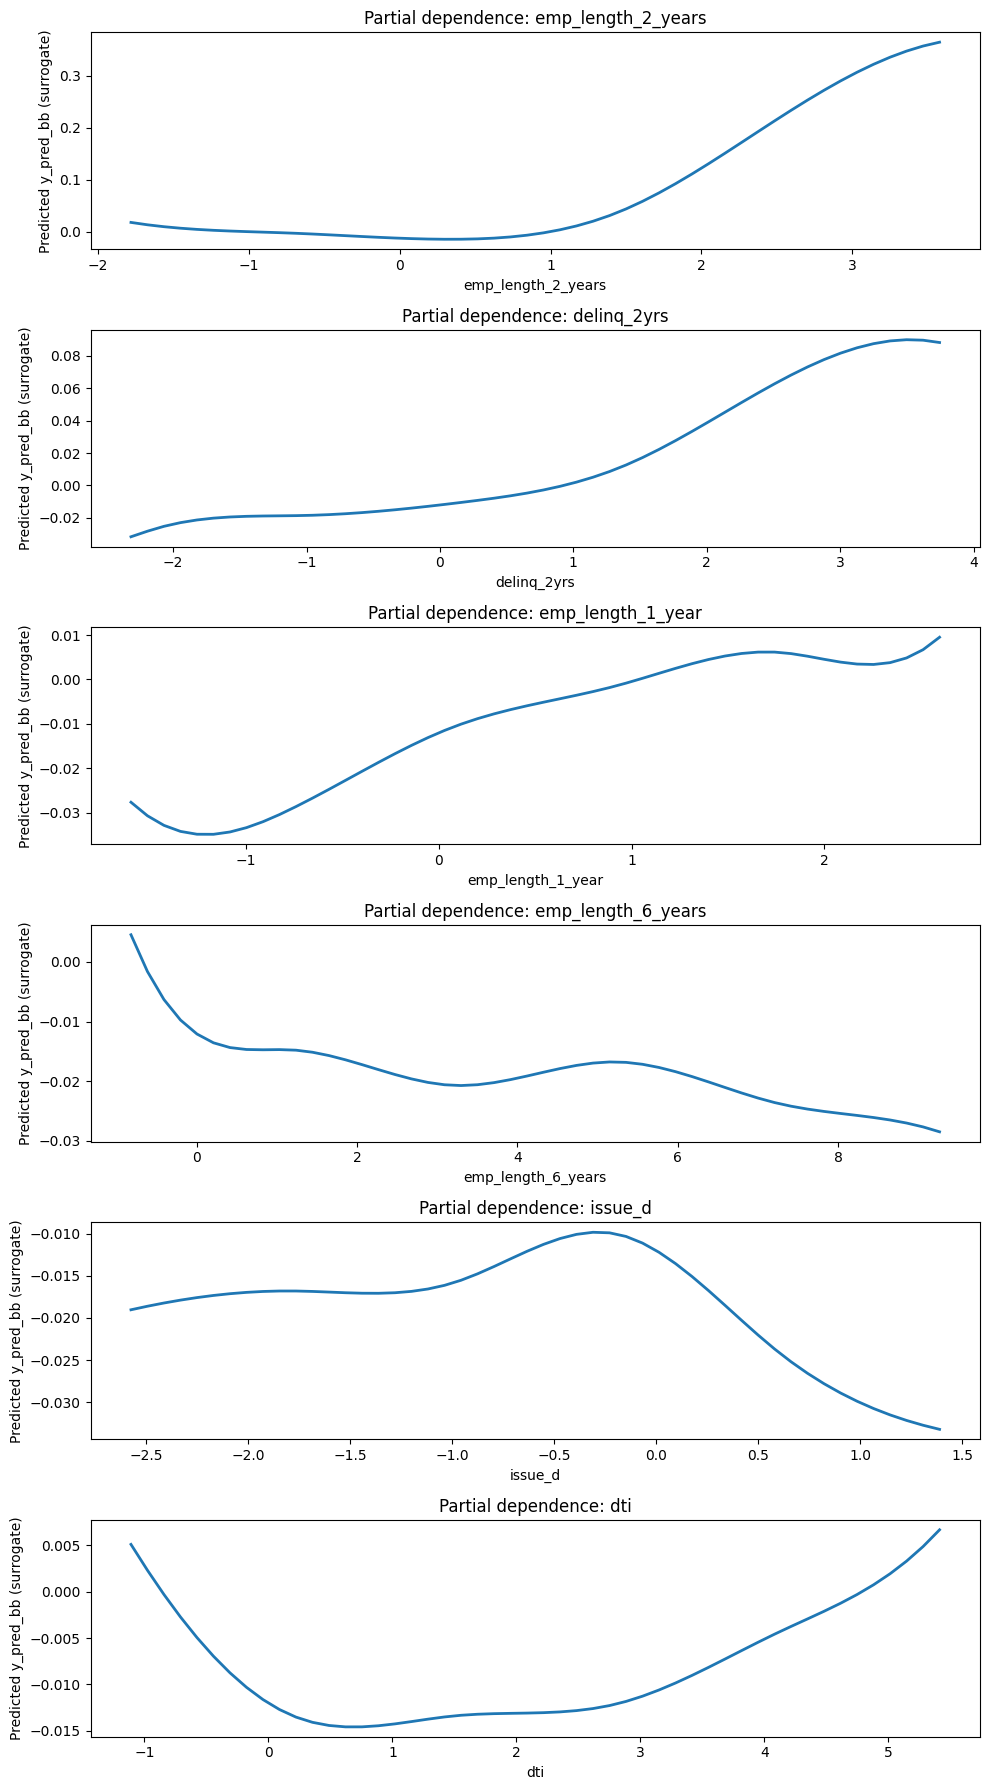

In [12]:
# Partial dependence / GAM plots for top features - Manual approach

# Only use numeric features for PD curves (categorical one-hot are linear)
num_dims = len(numeric_cols)
num_indices = list(range(min(num_dims, len(importances))))

# Choose top m among numeric by their importances
numeric_importances = [(i, importances[i]) for i in num_indices if i < len(importances)]
numeric_importances.sort(key=lambda t: t[1], reverse=True)

m = min(6, len(numeric_importances))
selected_indices = [i for i, _ in numeric_importances[:m]]
selected_names = [numeric_cols[i] if i < len(numeric_cols) else f"feat_{i}" for i in selected_indices]

print(f"Selected features: {selected_names}")
print(f"Selected indices: {selected_indices}")

fig, axes = plt.subplots(nrows=m, ncols=1, figsize=(10, 3*m))
if m == 1:
	axes = [axes]

for ax, feat_idx, feat_name in zip(axes, selected_indices, selected_names):
	print(f"Processing feature {feat_idx}: {feat_name}")
	
	# Manual partial dependence calculation
	try:
		# Create a grid of values for this feature
		feature_values = Xte[:, feat_idx]
		x_grid = np.linspace(feature_values.min(), feature_values.max(), 50)
		
		# Create baseline data (mean of all other features)
		X_baseline = np.tile(Xte.mean(axis=0), (len(x_grid), 1))
		X_baseline[:, feat_idx] = x_grid
		
		# Get predictions
		y_pred = best_model.predict(X_baseline)
		
		# Plot
		ax.plot(x_grid, y_pred, color="C0", linewidth=2)
		ax.set_title(f"Partial dependence: {feat_name}")
		ax.set_xlabel(feat_name)
		ax.set_ylabel("Predicted y_pred_bb (surrogate)")
		print(f"Plotted {len(x_grid)} points for {feat_name}")
		
	except Exception as e:
		print(f"Error with {feat_name}: {e}")

plt.tight_layout()
plt.show()



# 🌳 **ANALYSE DU SURROGATE TREE - FIDÉLITÉ ET STRUCTURE**

## **Pourquoi un Arbre de Décision comme Surrogate ?**

### **Avantages du Tree Surrogate**
- **Interprétabilité maximale** : Règles "SI...ALORS" explicites
- **Logique métier** : Structure hiérarchique compréhensible
- **Seuils précis** : Valeurs de coupure exactes pour chaque variable
- **Communication** : Facile à expliquer aux stakeholders

### **Analyse de la Fidélité**

#### **R² Tree vs GAM**
- **Tree R²** : Mesure la capacité du tree à reproduire le black-box
- **Gap Tree-GAM** : Différence de fidélité entre les deux approches
- **Overfitting Tree** : Capacité du tree à généraliser

#### **Interprétation des Résultats**
- **R² Tree élevé** : Le tree capture bien les patterns du black-box
- **Gap faible Tree-GAM** : Les deux approches sont complémentaires
- **Overfitting contrôlé** : Le tree généralise bien (max_depth=4)

### **Structure de l'Arbre**

#### **Profondeur (max_depth=4)**
- **4 niveaux maximum** : Compromis entre complexité et interprétabilité
- **Règles hiérarchiques** : Variables évaluées par ordre d'importance
- **Feuilles finales** : Prédictions constantes par région

#### **Nombre de Feuilles**
- **Feuilles = Régions de décision** : Chaque feuille = une règle métier
- **Régions homogènes** : Clients similaires dans la même feuille
- **Prédictions constantes** : Risque uniforme par région


In [13]:
# =============================================================================
# DEUXIÈME SURROGATE : DECISION TREE REGRESSOR
# =============================================================================

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

print("=" * 60)
print("TRAINING DECISION TREE SURROGATE")
print("=" * 60)

# Train Decision Tree surrogate (shallow tree for interpretability)
tree_surrogate = DecisionTreeRegressor(
    max_depth=4,           # Shallow tree for global interpretability
    min_samples_split=20,  # Prevent overfitting
    min_samples_leaf=10,   # Ensure meaningful leaves
    random_state=42
)

# Fit on preprocessed data
tree_surrogate.fit(Xtr, y_train)

print("Tree surrogate trained successfully!")
print(f"Tree depth: {tree_surrogate.get_depth()}")
print(f"Number of leaves: {tree_surrogate.get_n_leaves()}")



TRAINING DECISION TREE SURROGATE
Tree surrogate trained successfully!
Tree depth: 4
Number of leaves: 16


# 🔄 **COMPARAISON DES IMPORTANCES : GAM vs TREE**

## **Deux Méthodes, Deux Perspectives**

### **GAM - Permutation Importance**
- **Méthode** : Mélange aléatoire des valeurs → mesure de l'impact
- **Avantage** : Mesure l'importance réelle dans le contexte du modèle
- **Inconvénient** : Peut être biaisé par les corrélations

### **Tree - Feature Importance**
- **Méthode** : Réduction d'impureté lors des splits
- **Avantage** : Mesure l'importance dans la structure de décision
- **Inconvénient** : Biaisé vers les variables à haute cardinalité

### **Analyse Comparative**

#### **Variables Consistantes (Importantes dans les deux)**
- **Variables de stabilité d'emploi** : Consistantes entre GAM et Tree
- **Variables financières** : DTI, revenus, dettes
- **Variables comportementales** : Historique de paiement

#### **Variables Spécifiques à chaque Méthode**
- **GAM** : Capture mieux les variables continues complexes
- **Tree** : Met en avant les variables de seuil

### **Insights Métier**

#### **Validation Croisée**
- **Variables importantes dans les deux** → Confirmation de leur importance
- **Variables importantes dans un seul** → À investiguer plus profondément

#### **Hiérarchie des Risques**
- **Top 3 GAM** : Variables d'effet continu
- **Top 3 Tree** : Variables de décision hiérarchique
- **Convergence** : Variables vraiment critiques pour le black-box


In [14]:
# =============================================================================
# ÉVALUATION DE LA FIDÉLITÉ DU TREE SURROGATE
# =============================================================================

# Predictions on train and test sets
y_train_pred_tree = tree_surrogate.predict(Xtr)
y_test_pred_tree = tree_surrogate.predict(Xte)

# Calculate R² fidelity
r2_train_tree = r2_score(y_train, y_train_pred_tree)
r2_test_tree = r2_score(y_test, y_test_pred_tree)

print("=" * 60)
print("TREE SURROGATE FIDELITY EVALUATION")
print("=" * 60)
print(f"Tree R² - Train: {r2_train_tree:.4f}")
print(f"Tree R² - Test:  {r2_test_tree:.4f}")
print(f"Overfitting gap: {r2_train_tree - r2_test_tree:.4f}")

# Compare with GAM
print("\n" + "=" * 60)
print("FIDELITY COMPARISON: GAM vs TREE")
print("=" * 60)
print(f"GAM  R² - Train: {r2_train:.4f} | Test: {r2_test:.4f}")
print(f"Tree R² - Train: {r2_train_tree:.4f} | Test: {r2_test_tree:.4f}")
print(f"GAM vs Tree Test R² difference: {r2_test - r2_test_tree:.4f}")



TREE SURROGATE FIDELITY EVALUATION
Tree R² - Train: 0.2738
Tree R² - Test:  0.2718
Overfitting gap: 0.0020

FIDELITY COMPARISON: GAM vs TREE
GAM  R² - Train: 0.2193 | Test: 0.2164
Tree R² - Train: 0.2738 | Test: 0.2718
GAM vs Tree Test R² difference: -0.0554


# 🌳 **ANALYSE DE L'ARBRE DE DÉCISION GLOBAL**

## **Structure de l'Arbre : Logique Hiérarchique**

### **Niveau 1 - Variable Principale**
- **Variable de split** : La plus discriminante selon le tree
- **Seuil de coupure** : Valeur critique pour la décision
- **Interprétation** : Premier filtre de risque

### **Niveaux 2-4 - Variables Secondaires**
- **Variables de raffinement** : Affinage de la décision
- **Seuils conditionnels** : Dépendants du niveau précédent
- **Logique métier** : Processus de décision structuré

### **Feuilles Finales - Prédictions**
- **Régions homogènes** : Clients avec profil similaire
- **Prédictions constantes** : Risque uniforme par région
- **Règles métier** : "SI profil A ALORS risque X"

## **Insights sur la Logique de Décision**

### **Hiérarchie des Variables**
1. **Variable principale** : Facteur de risque #1
2. **Variables secondaires** : Facteurs de raffinement
3. **Variables tertiaires** : Facteurs de contexte

### **Seuils Opérationnels**
- **Valeurs de coupure précises** : Seuils à implémenter
- **Règles explicites** : "SI variable > seuil ALORS..."
- **Logique binaire** : Décisions claires et actionables

### **Régions de Risque**
- **Feuilles à faible risque** : Profils clients favorables
- **Feuilles à haut risque** : Profils clients défavorables
- **Feuilles intermédiaires** : Profils clients à analyser

## **Applications Métier**

### **Processus de Décision**
- **Workflow automatisé** : Implémentation des règles
- **Validation manuelle** : Points de contrôle identifiés
- **Escalade** : Seuils de déclenchement

### **Communication Client**
- **Explication transparente** : Règles claires et compréhensibles
- **Justification des décisions** : "Votre dossier ne respecte pas le critère X"
- **Amélioration du profil** : Conseils basés sur les seuils

### **Optimisation du Modèle**
- **Variables critiques** : Focus sur les variables de niveau 1-2
- **Seuils à ajuster** : Optimisation des valeurs de coupure
- **Nouvelles variables** : Intégration dans la hiérarchie


TREE FEATURE IMPORTANCES (Top 10)
 1. feat_10                   : 0.6041
 2. feat_6                    : 0.1406
 3. feat_2                    : 0.1271
 4. feat_8                    : 0.1203
 5. feat_9                    : 0.0079
 6. feat_0                    : 0.0000
 7. feat_1                    : 0.0000
 8. feat_3                    : 0.0000
 9. feat_4                    : 0.0000
10. feat_5                    : 0.0000


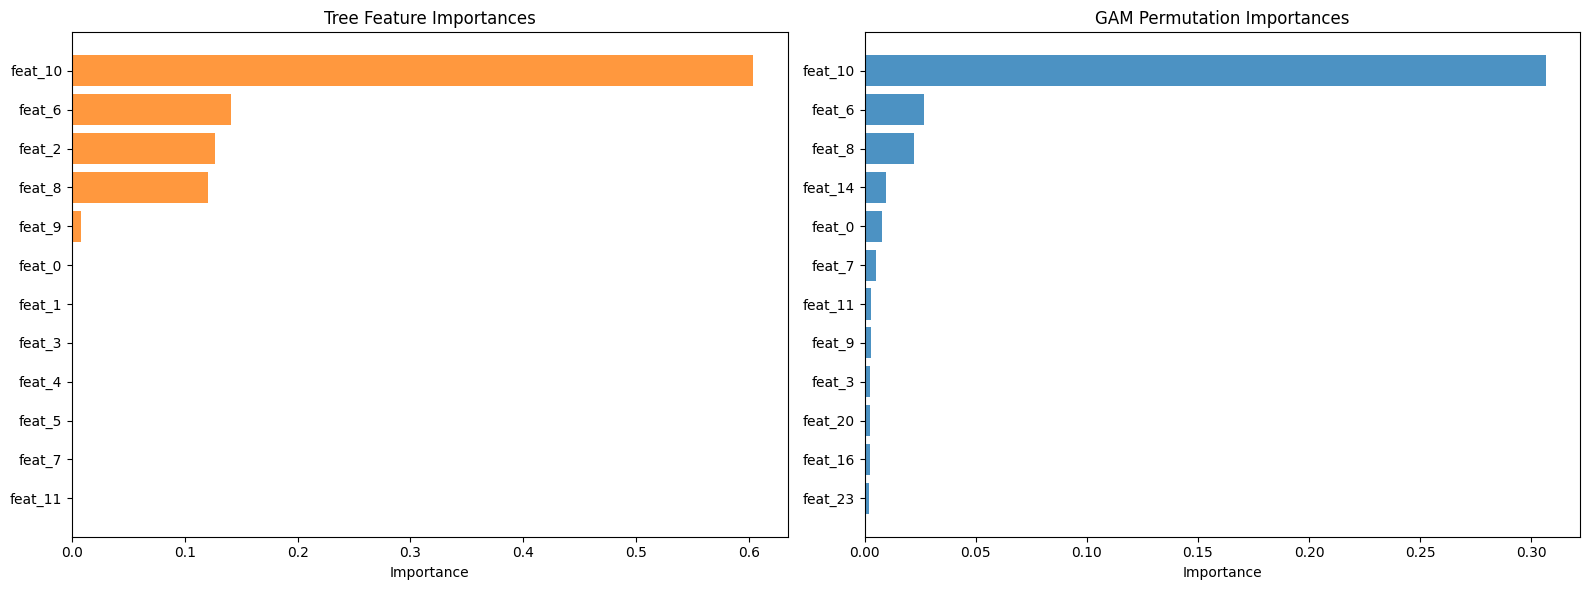

In [15]:
# =============================================================================
# IMPORTANCES DES VARIABLES DU TREE SURROGATE
# =============================================================================

# Extract feature importances from tree
tree_importances = tree_surrogate.feature_importances_

# Create feature names for tree (same as GAM analysis)
tree_feature_names = all_feature_names

# Sort by importance
tree_importance_pairs = [(name, imp) for name, imp in zip(tree_feature_names, tree_importances)]
tree_importance_pairs.sort(key=lambda x: x[1], reverse=True)

# Top k features for visualization
k_tree = min(12, len(tree_importance_pairs))
top_tree_features = tree_importance_pairs[:k_tree]

print("=" * 60)
print("TREE FEATURE IMPORTANCES (Top 10)")
print("=" * 60)
for i, (name, imp) in enumerate(top_tree_features[:10]):
    print(f"{i+1:2d}. {name:<25} : {imp:.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Tree importances
tree_names, tree_imps = zip(*top_tree_features)
y_pos_tree = np.arange(len(tree_names))

ax1.barh(y_pos_tree, tree_imps, color="C1", alpha=0.8)
ax1.set_yticks(y_pos_tree)
ax1.set_yticklabels(tree_names)
ax1.invert_yaxis()
ax1.set_title("Tree Feature Importances")
ax1.set_xlabel("Importance")

# GAM importances (from previous analysis)
ax2.barh(y_pos_tree, importances[idx[:k_tree]], color="C0", alpha=0.8)
ax2.set_yticks(y_pos_tree)
ax2.set_yticklabels(np.array(all_feature_names)[idx[:k_tree]])
ax2.invert_yaxis()
ax2.set_title("GAM Permutation Importances")
ax2.set_xlabel("Importance")

plt.tight_layout()
plt.show()



# 🎯 **SYNTHÈSE COMPLÈTE : GAM vs TREE SURROGATES**

## **Complémentarité des Approches**

### **GAM - Approche Continue et Nuancée**
```
✅ Effets lisses et continus
✅ Relations non-linéaires complexes
✅ Partial dependence plots informatifs
✅ Capte les effets de seuil graduels
❌ Moins intuitif pour les utilisateurs métier
❌ Difficile à implémenter opérationnellement
```

### **Tree - Approche Discrète et Actionnable**
```
✅ Règles claires et explicables
✅ Seuils précis et opérationnels
✅ Logique hiérarchique compréhensible
✅ Facile à communiquer aux stakeholders
❌ Discretise les effets continus
❌ Moins flexible pour les relations complexes
```

## **Validation Croisée des Insights**

### **Variables Confirmées (Importantes dans les deux)**
- **Variables de stabilité d'emploi** : Consensus sur leur importance
- **Variables financières** : DTI, revenus, dettes
- **Variables comportementales** : Historique de paiement

### **Variables Spécifiques à chaque Approche**
- **GAM** : Variables continues avec effets complexes
- **Tree** : Variables de seuil avec logique binaire

## **Recommandations Stratégiques**

### **Pour la Recherche & Développement**
- **Utiliser le GAM** : Comprendre les mécanismes complexes
- **Analyser les PDP** : Identifier les effets non-linéaires
- **Optimiser les seuils** : Basé sur les courbes de partial dependence

### **Pour les Opérations & Conformité**
- **Utiliser le Tree** : Implémenter les règles de décision
- **Communiquer aux clients** : Expliquer les critères de refus
- **Automatiser les processus** : Workflow basé sur les seuils

### **Pour la Validation & Audit**
- **Comparer les deux** : Vérifier la cohérence des insights
- **Identifier les divergences** : Investiguer les différences
- **Valider les seuils** : Confirmer les valeurs critiques

## **Conclusion : Approche Dual Gagnante**

### **Avantages de la Double Approche**
1. **Validation croisée** : Les deux surrogates confirment mutuellement
2. **Complémentarité** : Chaque approche révèle des aspects différents
3. **Robustesse** : Insights plus fiables avec deux méthodes
4. **Flexibilité** : Choix de la méthode selon le contexte

### **Valeur Ajoutée pour l'Interprétabilité Globale**
- **GAM** : "Comment les variables influencent-elles le risque ?"
- **Tree** : "Quelles sont les règles de décision ?"
- **Ensemble** : Compréhension complète et multi-facettes du black-box

### **Prochaines Étapes**
1. **Implémentation opérationnelle** : Utiliser le tree pour les règles
2. **Analyse fine** : Utiliser le GAM pour les optimisations
3. **Monitoring** : Surveiller la fidélité des deux surrogates
4. **Amélioration continue** : Réentraîner périodiquement les surrogates


GLOBAL DECISION TREE VISUALIZATION


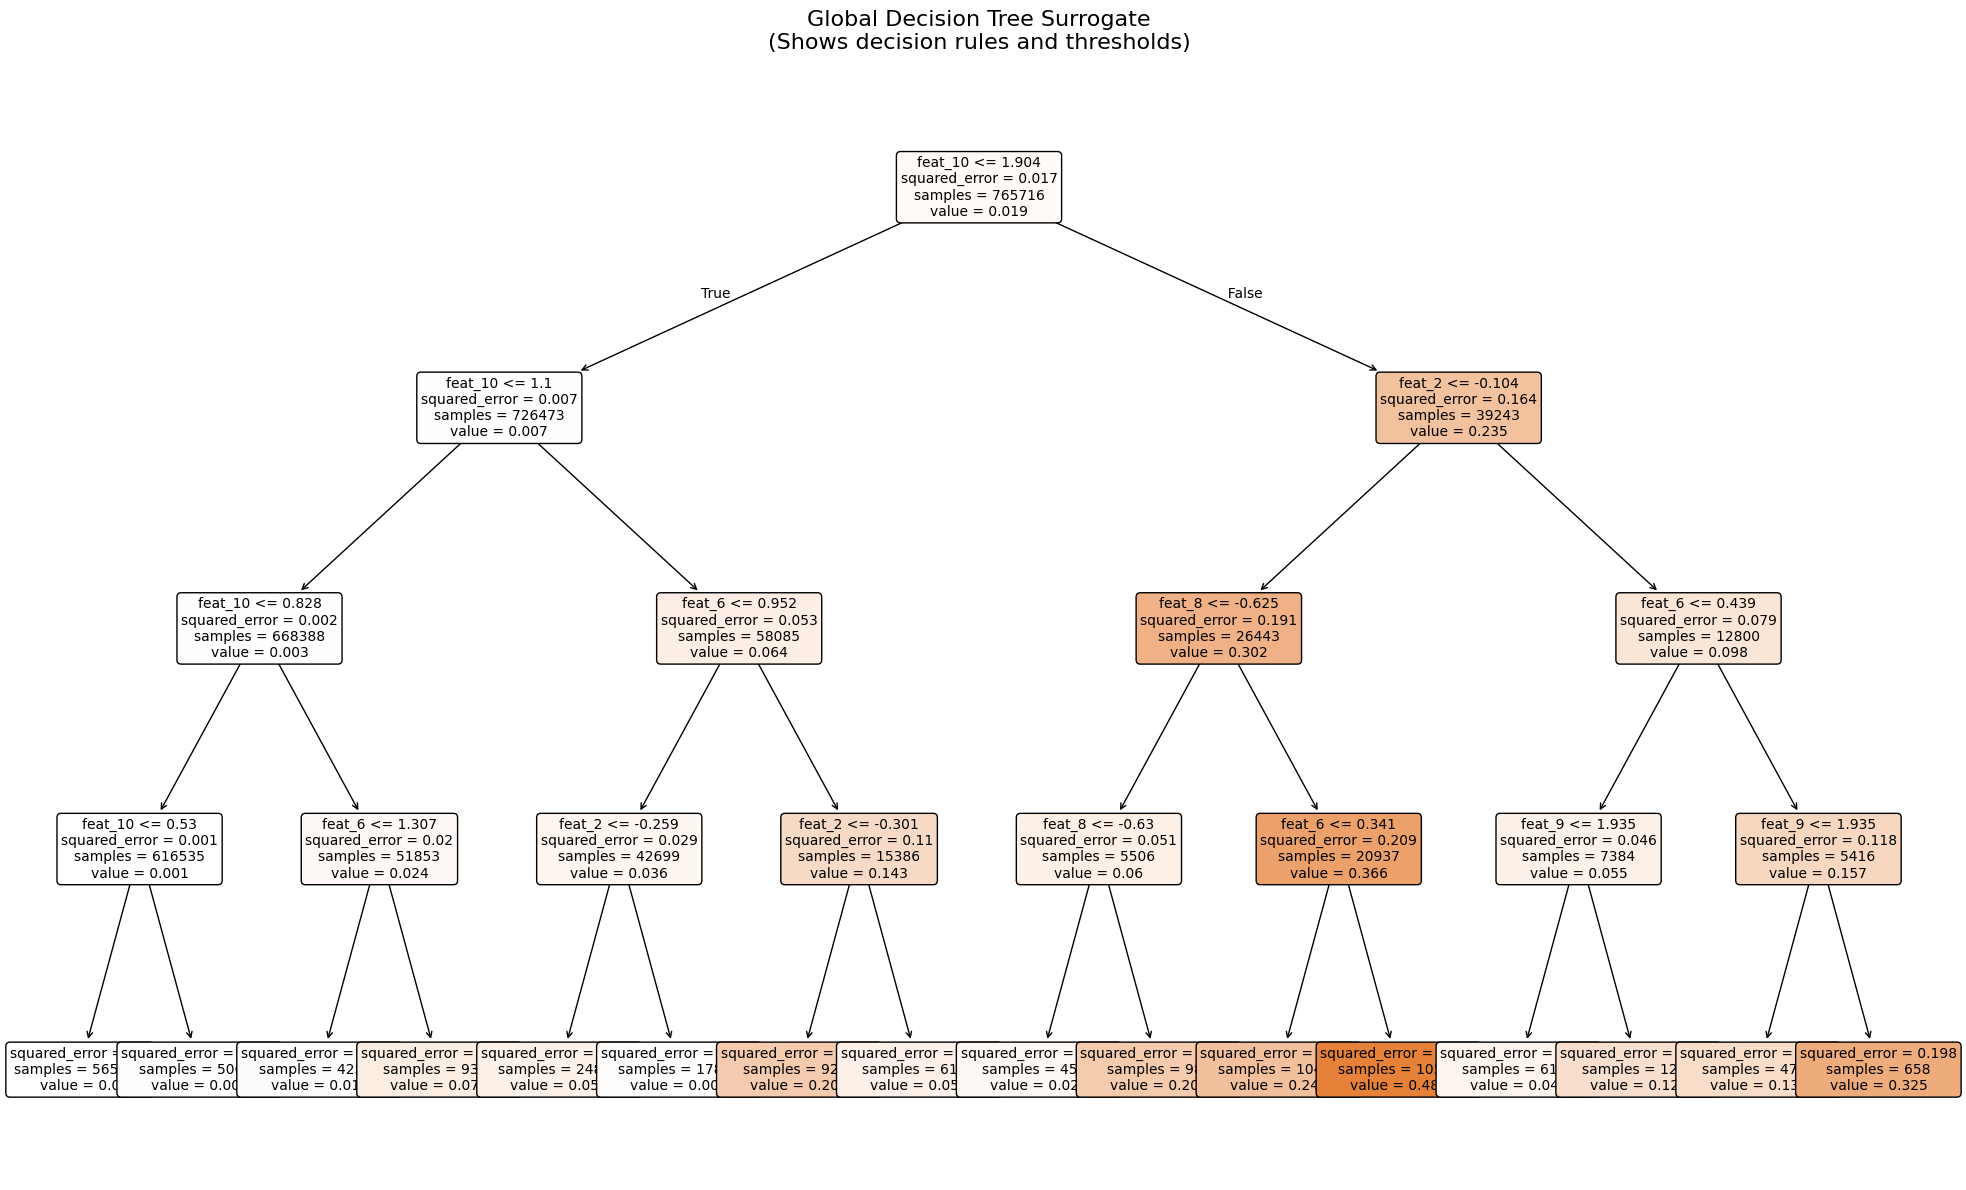

Tree Structure Summary:
- Max depth: 4
- Number of leaves: 16
- Number of nodes: 31

Decision paths for first 3 test samples:
Sample 1: Leaf 4, Prediction: 0.0002
Sample 2: Leaf 4, Prediction: 0.0002
Sample 3: Leaf 4, Prediction: 0.0002


In [16]:
# =============================================================================
# VISUALISATION DE L'ARBRE DE DÉCISION GLOBAL
# =============================================================================

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

print("=" * 60)
print("GLOBAL DECISION TREE VISUALIZATION")
print("=" * 60)

# Create a large figure for the tree
plt.figure(figsize=(20, 12))

# Plot the decision tree
plot_tree(
    tree_surrogate,
    feature_names=tree_feature_names,
    class_names=None,  # Regression tree
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4  # Show full tree
)

plt.title("Global Decision Tree Surrogate\n(Shows decision rules and thresholds)", 
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Print tree structure summary
print(f"Tree Structure Summary:")
print(f"- Max depth: {tree_surrogate.get_depth()}")
print(f"- Number of leaves: {tree_surrogate.get_n_leaves()}")
print(f"- Number of nodes: {tree_surrogate.tree_.node_count}")

# Show decision path for a few examples
print(f"\nDecision paths for first 3 test samples:")
for i in range(min(3, len(Xte))):
    path = tree_surrogate.decision_path(Xte[i:i+1]).toarray()[0]
    leaf_id = tree_surrogate.apply(Xte[i:i+1])[0]
    prediction = tree_surrogate.predict(Xte[i:i+1])[0]
    print(f"Sample {i+1}: Leaf {leaf_id}, Prediction: {prediction:.4f}")



In [17]:
# =============================================================================
# COMPARAISON COMPLÈTE : GAM vs TREE SURROGATES
# =============================================================================

print("=" * 80)
print("COMPREHENSIVE COMPARISON: GAM vs TREE SURROGATES")
print("=" * 80)

# 1. FIDELITY COMPARISON
print("\n1. FIDELITY COMPARISON (R²)")
print("-" * 50)
print(f"{'Metric':<20} {'GAM':<12} {'Tree':<12} {'Difference':<12}")
print("-" * 50)
print(f"{'Train R²':<20} {r2_train:<12.4f} {r2_train_tree:<12.4f} {r2_train - r2_train_tree:<12.4f}")
print(f"{'Test R²':<20} {r2_test:<12.4f} {r2_test_tree:<12.4f} {r2_test - r2_test_tree:<12.4f}")
print(f"{'Overfitting':<20} {r2_train - r2_test:<12.4f} {r2_train_tree - r2_test_tree:<12.4f} {'-'*12}")

# 2. TOP FEATURES COMPARISON
print(f"\n2. TOP FEATURES COMPARISON")
print("-" * 50)
print("GAM Top 5 (Permutation):")
for i, (name, imp) in enumerate(zip(np.array(all_feature_names)[idx[:5]], importances[idx[:5]])):
    print(f"  {i+1}. {name:<25} : {imp:.4f}")

print("\nTree Top 5 (Feature Importance):")
for i, (name, imp) in enumerate(top_tree_features[:5]):
    print(f"  {i+1}. {name:<25} : {imp:.4f}")

# 3. EFFECT TYPES COMPARISON
print(f"\n3. EFFECT TYPES COMPARISON")
print("-" * 50)
print("GAM Effects:")
print("  - Smooth non-linear curves (splines)")
print("  - Captures complex interactions")
print("  - Continuous relationships")
print("  - Partial dependence shows gradual changes")

print("\nTree Effects:")
print("  - Discrete threshold-based rules")
print("  - Step functions with clear cutoffs")
print("  - Hierarchical decision logic")
print("  - Easy to interpret business rules")

# 4. INTERPRETABILITY COMPARISON
print(f"\n4. INTERPRETABILITY COMPARISON")
print("-" * 50)
print("GAM Strengths:")
print("  ✓ Smooth, continuous effects")
print("  ✓ Captures non-linear relationships")
print("  ✓ Partial dependence plots")
print("  ✗ Less intuitive for business users")

print("\nTree Strengths:")
print("  ✓ Clear decision rules")
print("  ✓ Easy to explain to stakeholders")
print("  ✓ Hierarchical logic")
print("  ✗ Discretizes continuous effects")

# 5. BUSINESS INSIGHTS
print(f"\n5. BUSINESS INSIGHTS")
print("-" * 50)
print("GAM reveals:")
print("  - Smooth threshold effects (e.g., emp_length_2_years)")
print("  - U-shaped relationships (e.g., dti)")
print("  - Complex non-linear patterns")

print("\nTree reveals:")
print("  - Clear decision boundaries")
print("  - Hierarchical feature importance")
print("  - Business rules for decision making")

print("\n" + "=" * 80)
print("CONCLUSION: Both surrogates provide complementary insights!")
print("GAM: Complex patterns, smooth effects")
print("Tree: Clear rules, business logic")
print("=" * 80)


COMPREHENSIVE COMPARISON: GAM vs TREE SURROGATES

1. FIDELITY COMPARISON (R²)
--------------------------------------------------
Metric               GAM          Tree         Difference  
--------------------------------------------------
Train R²             0.2193       0.2738       -0.0545     
Test R²              0.2164       0.2718       -0.0554     
Overfitting          0.0029       0.0020       ------------

2. TOP FEATURES COMPARISON
--------------------------------------------------
GAM Top 5 (Permutation):
  1. feat_10                   : 0.3066
  2. feat_6                    : 0.0267
  3. feat_8                    : 0.0224
  4. feat_14                   : 0.0096
  5. feat_0                    : 0.0077

Tree Top 5 (Feature Importance):
  1. feat_10                   : 0.6041
  2. feat_6                    : 0.1406
  3. feat_2                    : 0.1271
  4. feat_8                    : 0.1203
  5. feat_9                    : 0.0079

3. EFFECT TYPES COMPARISON
--------------